# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [41]:
import numpy as np
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import PIL
from pkg_resources import packaging

print("Torch version:", torch.__version__)


Torch version: 1.8.0


In [42]:
import os

import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import skimage

from collections import OrderedDict
import torch

# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [43]:
import clip

clip.available_models()
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [44]:
model, preprocess = clip.load("/hy-tmp/clip_model/ViT-B-32.pt", device)
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [45]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f1e5625b280>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [46]:
# text_tensor = clip.tokenize(["Hello World!", "helloworld", "heeee"]).to(device)
# print(text_tensor)
# test_tensor = model.encode_text(text_tensor)
# print(test_tensor)
# print(test_tensor.size())

In [72]:
text = ["The number of islands on an aircraft carrier is 1, the bow shape is blunt, and the hull has a flat runway.", 
"The number of islands on a destroyer is 1, the bow shape is pointed, and the hull has a fluctuating island.", 
"The number of islands on a cruiser is 2, the bow shape is pointed, and the hull has a fluctuating island.", 
"The number of islands on a supply ship is 2, the bow shape is pointed, and the hull has a fluctuating gantry and a fluctuating island.", 
"A cruise ship has no islands, the bow shape is pointed, and the hull has cabins."]

In [73]:
text_tensor = clip.tokenize(text).to(device)
test_tensor = model.encode_text(text_tensor).float()

In [74]:
test_tensor.size()

torch.Size([5, 512])

In [75]:
test_tensor

tensor([[ 2.3352e-01,  1.3281e-01,  2.4988e-01,  ...,  9.3604e-01,
          2.6123e-01, -6.2622e-02],
        [ 1.9666e-01, -2.0569e-01,  2.0276e-01,  ...,  6.2012e-01,
          1.1700e-01, -1.1047e-01],
        [ 2.0093e-01, -9.9609e-02,  5.1086e-02,  ...,  4.9927e-01,
          1.3757e-01,  7.2432e-04],
        [ 3.6816e-01, -2.9810e-01, -5.1361e-02,  ...,  1.5051e-01,
          1.8982e-01, -3.1494e-02],
        [ 6.9458e-02, -2.5903e-01,  1.2901e-02,  ...,  7.0996e-01,
         -1.2073e-01, -2.0691e-01]], device='cuda:0', grad_fn=<CopyBackwards>)

In [76]:
from dall_e          import map_pixels, unmap_pixels, load_model
from IPython.display import display, display_markdown

target_image_size = 256
def preprocess_img(img):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    # img = torch.unsqueeze(T.ToTensor()(img), 0)
    return img

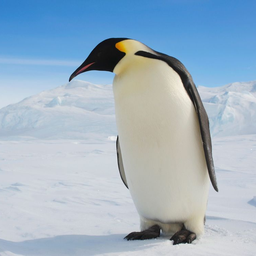

In [77]:
image = preprocess_img(PIL.Image.open("/hy-tmp/1000x-1.jpg"))
image.show()

# display_markdown('Original image:')
# display(T.ToPILImage(mode='RGB')(image[0]))

In [78]:
# image.size()

In [83]:
images = []
images.append(preprocess(image))
images.append(preprocess(image))

In [84]:
image_input = torch.tensor(np.stack(images)).to(device)

In [85]:
image_input.size()

torch.Size([2, 3, 224, 224])

In [86]:
model.encode_image(image_input).float()

tensor([[ 0.0168, -0.1085,  0.2164,  ...,  0.1660,  0.2893, -0.2461],
        [ 0.0168, -0.1085,  0.2164,  ...,  0.1660,  0.2893, -0.2461]],
       device='cuda:0', grad_fn=<CopyBackwards>)

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

In [ ]:
original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
  
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))  # 自带
    texts.append(descriptions[name])

plt.tight_layout()


## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [ ]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [ ]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating cosine similarity

We normalize the features and calculate the dot product of each pair.

In [ ]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

In [ ]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [ ]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

In [ ]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [ ]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

In [ ]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()